## HW6 by Denis Osipychev
# Proximal Policy Optimization Algorithms

### Hyper parameters and service functions

In [ ]:
# import env and modules
import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim

In [2]:
# create an instance of env
env = gym.make('Pendulum-v0')
env.reset()

array([-0.71562238, -0.69848738,  0.6366009 ])

In [3]:
class PPOagent():
    def __init__(self, lr, s_size,a_size,h_size):
        
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        
        # Value network
        hidden1 = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.tanh)
        self.value = slim.fully_connected(hidden1,1,biases_initializer=None)
        
        # Policy network
        hidden2 = slim.fully_connected(self.state_in,h_size,biases_initializer=None,activation_fn=tf.nn.tanh)
        p_mean = slim.fully_connected(hidden2,a_size,activation_fn=tf.nn.tanh,biases_initializer=None)
        p_var = slim.fully_connected(hidden2,a_size,activation_fn=tf.nn.softplus,biases_initializer=None)
        prob_distr = tf.distributions.Normal(loc=p_mean, scale=p_var)
        self.action = prob_distr.sample(1)
        self.log_prob = prob_distr.log_prob(self.action)
        
        # loss for V network
        self.v_target = tf.placeholder(shape=[None],dtype=tf.float32)
        v_loss = tf.reduce_mean(tf.square(self.v_target - self.value))
        
        # loss for Policy network (A value)
        self.old_log_prob = tf.placeholder(shape=[None],dtype=tf.float32)
        self.a_target = tf.placeholder(shape=[None],dtype=tf.float32)
               
        ratio = tf.exp(self.log_prob - self.old_log_prob) # pnew / pold
        surr_loss = ratio * self.a_target # surrogate from conservative policy iteration
        surr_loss_clip = tf.clip_by_value(ratio, 1.0 - 0.2, 1.0 + 0.2) * self.a_target #
        p_loss = - tf.reduce_mean(tf.minimum(surr_loss, surr_loss_clip))
        
        # total loss function
        total_loss = p_loss + v_loss
        
        #tvars = tf.trainable_variables()
        self.optimizer = tf.train.AdamOptimizer(alpha).minimize(total_loss)

In [ ]:
# def traj2v_a(s_arr, a_arr, r_arr, s_new_arr, v_arr):
    
#     new_state = np.append(s_new_arr, 0) # last element is only used for last vtarg, but we already zeroed it if last new = 1
#     v_predicted = np.append(v_arr, r_arr[-1])
#     T = len(r_arr)
#     advantage = np.empty(T, 'float32')
#     gaelam = np.empty(T, 'float32')
#     lastgaelam = 0
#     for t in reversed(range(T)):
#         nonterminal = 1 - new_state[t+1]
#         delta = r_arr[t] + gamma * v_predicted[t+1] * nonterminal - v_predicted[t]
#         gaelam[t] = delta + gamma * lambd * nonterminal * lastgaelam
#         lastgaelam = gaelam[t]
#         advantage[t] = gaelam[t]
#     tdlamret = advantage + v_predicted
#     return tdlamret, advantage

In [ ]:
# def v_and_a(s_arr, a_arr, r_arr, s_new_arr, v_arr, gamma, lambd):
    
#     new_state = np.append(s_new_arr, 0) # last element is only used for last vtarg, but we already zeroed it if last new = 1
#     v_predicted = np.append(v_arr, r_arr[-1])
#     T = len(r_arr)
#     advantage = np.empty(T, 'float32')
#     gaelam = np.empty(T, 'float32')
#     lastgaelam = 0
#     for t in reversed(range(T)):
#         nonterminal = 1 - new_state[t+1]
#         delta = r_arr[t] + gamma * v_predicted[t+1] * nonterminal - v_predicted[t]
#         gaelam[t] = delta + gamma * lam * nonterminal * lastgaelam
#         lastgaelam = gaelam[t]
#         advantage[t] = gaelam[t]
#     tdlamret = advantage + v_predicted
#     return tdlamret, advantage

In [4]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, arg):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = arg
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            batch_size = len(self.memory)
        return random.sample(self.memory, batch_size)
    
    def size(self):
        return len(self.memory)

In [ ]:
def compute_v(r_batch, v_new_batch):
    v_next = np.asarray(v_new_batch).flatten()
    reward = np.asarray(r_batch).flatten()
    return reward + v_next*gamma
    
def compute_a(discounted_r, v):
    discounted_r = np.asarray(discounted_r).flatten()
    v = np.asarray(v).flatten()
    gae = discounted_r - v
    return gae

In [5]:
# initialize hyperparams for PG
n_episodes = 5000
episode_length = 100
gamma = 0.99
alpha = 0.0001
lambd = lam = 1
epsilon = 0.2
update_freq = 10
buffer_size = 1000
batch_size = 100

In [6]:
# TF variables reset
tf.reset_default_graph()
myAgent = PPOagent(lr=alpha,s_size=3,a_size=1,h_size=20)
init = tf.global_variables_initializer()

In [7]:
with tf.Session() as sess:
    
    sess.run(init)
    
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    
    stats = []
    buffer = ReplayMemory(buffer_size)
    i_episode = 0
    
    while i_episode < n_episodes:
        
        s = env.reset()
        s = np.array(s).reshape(1, 3)
        running_reward = 0
        trajectory = []
        i_episode += 1
        
        for t in range(episode_length):
            
            action, plog = sess.run([myAgent.action,myAgent.log_prob],
                                     feed_dict={myAgent.state_in:s})

            s_new,r,d,_ = env.step(action)
            
            #populate the trajectory
            trajectory.append([s,action,r,s_new,plog])
            #buffer.push([s,action,r,s_new,plog])
    
            prev_action = action
            s = np.array(s_new).reshape(1, 3)
            running_reward += r
            
            if d == True:
                
                buffer.push(trajectory)
                break
                
        # sample the trajectories
        batch = buffer.sample(batch_size)
        
        #do update for each trajectory in the batch
        for traj in batch:
            s_arr, a_arr, r_arr, s_new_arr, p_arr = zip(*traj)
            v_new_arr = sess.run(myAgent.value, feed_dict={myAgent.state_in:s_new_arr})
            v_arr = sess.run(myAgent.value, feed_dict={myAgent.state_in:s_arr})
            v_target_arr = compute_v(r_arr,v_new_arr)
            a_target_arr = compute_a(v_target_arr, v_arr)
        
            feed_dict={myAgent.state_in:s_arr,
                        myAgent.old_log_prob:p_arr,
                        myAgent.a_target:a_target_arr,
                        myAgent.v_target:v_target_arr}
            _ = sess.run(myAgent.optimizer, feed_dict=feed_dict)
                    
        # Update statistics
        stats.append([i_episode,running_reward])
        
        if i_episode % 100 == 0:
            print(' Epoch:',i_episode,',Average R:',np.mean(np.asarray(stats)[-100:,1]))
    

 Epoch: 100 ,Average R: -594.9123300170899
 Epoch: 200 ,Average R: -606.5799978637696
 Epoch: 300 ,Average R: -614.8857260131836
 Epoch: 400 ,Average R: -592.9326348876953
 Epoch: 500 ,Average R: -589.971086730957
 Epoch: 600 ,Average R: -609.7478033447265
 Epoch: 700 ,Average R: -604.5405825805664
 Epoch: 800 ,Average R: -600.0023239135742
 Epoch: 900 ,Average R: -600.5494659423828
 Epoch: 1000 ,Average R: -609.4274411010742
 Epoch: 1100 ,Average R: -595.2545462036132
 Epoch: 1200 ,Average R: -604.5076651000977
 Epoch: 1300 ,Average R: -592.4987307739258
 Epoch: 1400 ,Average R: -591.0888497924805
 Epoch: 1500 ,Average R: -594.3765417480469
 Epoch: 1600 ,Average R: -611.8899365234375
 Epoch: 1700 ,Average R: -594.6014654541016
 Epoch: 1800 ,Average R: -595.0692581176758
 Epoch: 1900 ,Average R: -602.3887823486328
 Epoch: 2000 ,Average R: -605.5490240478516
 Epoch: 2100 ,Average R: -601.0630804443359
 Epoch: 2200 ,Average R: -594.6235430908204
 Epoch: 2300 ,Average R: -601.108345031738

KeyboardInterrupt: 

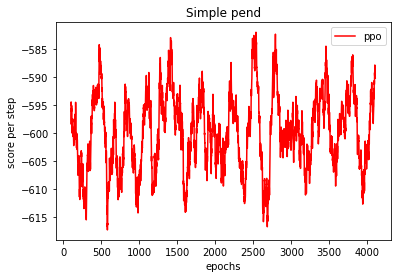

In [9]:
#plot the results (taken from https://gist.github.com/vksah32/8ba7ee7489bd8ec50c995f6216adcb7d)
import pandas as pd
import matplotlib.pyplot as plt 

i,r = zip(*stats)
r_np = np.asarray(r).flatten()
i_np = np.asarray(i).flatten()

mean_x1 = pd.Series(r_np).rolling(window=100).mean()

plt.xlabel("epochs")
plt.ylabel("score per step")
plt.plot(i_np, mean_x1, 'r-')
plt.legend(['ppo'])
plt.title('Simple pend')
plt.show()

## still not working (